# Partial Exam GLM

@roman avj

11 March 2024

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

import pymc as pm
import arviz as az
import xarray as xr

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


---
# Q1: Argentina Mortgage Data

Let $\theta$ be the rate of mortgage loans granted by a bank in Argentina. During 2023 the average rate was 60% and the standard deviation of the rate was 0.04. So far in 2024, 100 loans have been requested, of which only 50 have been granted.



## Q1.A: Beta Prior

Using the information from last year, find the beta distribution that best describes the initial knowledge


In [31]:
# solve system of equations
from scipy.optimize import fsolve

# define the system of equations
def equations(vars, b1, b2):
    # unpack
    alpha, beta = vars

    # define the equations as the mean and variance of a beta
    eq1 = alpha / (alpha + beta) - b1
    eq2 = (alpha * beta) / ((alpha + beta)**2 * (alpha + beta + 1)) - b2
    return [eq1, eq2]

# initial guess
init_guess = [1, 1]

# solve
alpha0, beta0 = fsolve(equations, init_guess, args=(0.6, 0.04**2))

# print
print(f"alpha: {alpha0:.2f}, beta: {beta0:.2f}")


alpha: 89.40, beta: 59.60


In [32]:
# check if the solution is correct
mean0 = alpha0 / (alpha0 + beta0)
variance0 = (alpha0 * beta0) / ((alpha0 + beta0)**2 * (alpha0 + beta0 + 1))
print(f"mean: {mean0:.2f}, std dev: {np.sqrt(variance0):.4f}")

mean: 0.60, std dev: 0.0400


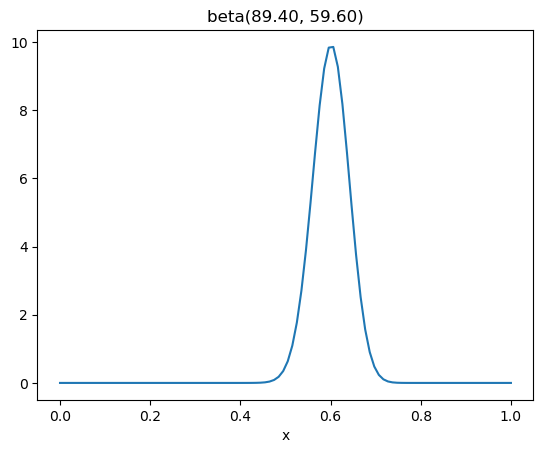

In [35]:
# plot the beta distribution
from scipy.stats import beta
x = np.linspace(0, 1, 100)
y = beta.pdf(x, float(alpha0), float(beta0))
plt.plot(x, y)
plt.title(f"beta({alpha0:.2f}, {beta0:.2f})")
plt.xlabel("x")
plt.show()

## Q1.B: Transformed Normal Distribution

Using the information from the previous year, find the transformed normal distribution that best describes the initial knowledge.


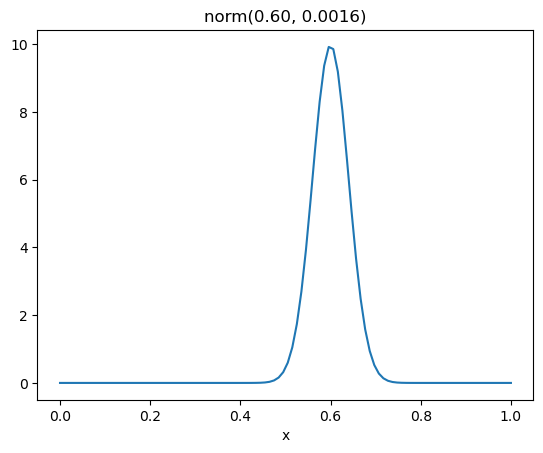

In [36]:
# we will suppose x ~ norm(0.6, 0.04**2)
from scipy.stats import norm

# params
mean0 = 0.6
variance0 = 0.04**2

# graph the normal distribution
x = np.linspace(0, 1, 100)
y = norm.pdf(x, loc=mean0, scale=np.sqrt(variance0))
plt.plot(x, y)
plt.title(f"norm({mean0:.2f}, {variance0:.4f})")
plt.xlabel("x")
plt.show()


## Q1.C: Initial Non-Informative Prior

Determine the inicial non-informative prior for the parameter $\theta$

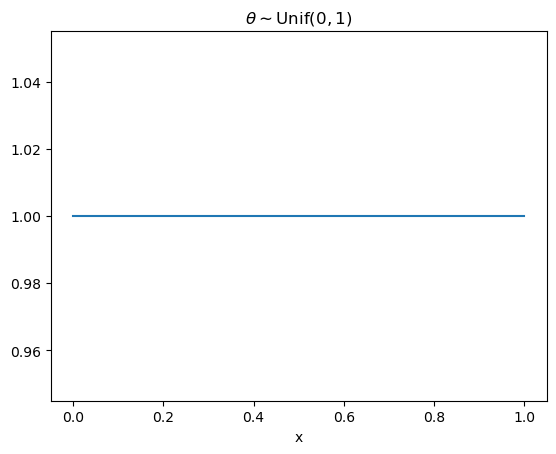

In [39]:
# we will assume \theta \propto 1 (but maybe is baised by jeffreys prior for beta distribution)
x = np.linspace(0, 1, 100)
y = np.repeat(1, 100)
plt.plot(x, y)
plt.title(r"$\theta \sim \text{Unif}(0,1)$")
plt.xlabel("x")
plt.show()

## Q1.D: Analytical Posterior distribution for 1.A, 1.B, 1.C

In [ ]:
# q1.d.a easy
# q1.d.b (wip)
# q1.d.c easy

## Q1.E: PyMC Posterior for 1.A, 1.B, 1.C

In [41]:
# 2005 params
n_obs = 100
n_success = 60

#### 1.A model

In [50]:
# posterior distribution for 1.a
with pm.Model() as model_1a:
    # prior
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1a = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1a = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1a = pm.sample_posterior_predictive(trace_1a, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Sampling: [y]


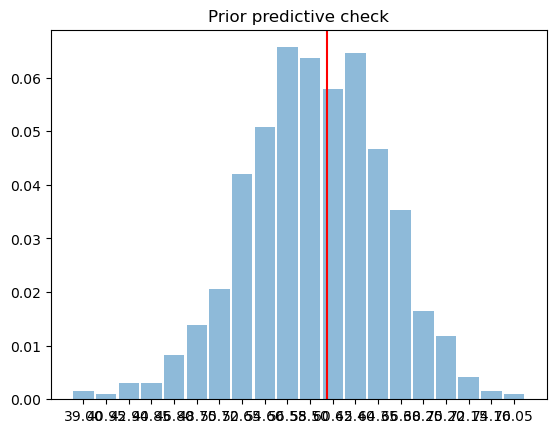

In [52]:
# prior predictive check
az.plot_dist(
    prior_1a.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

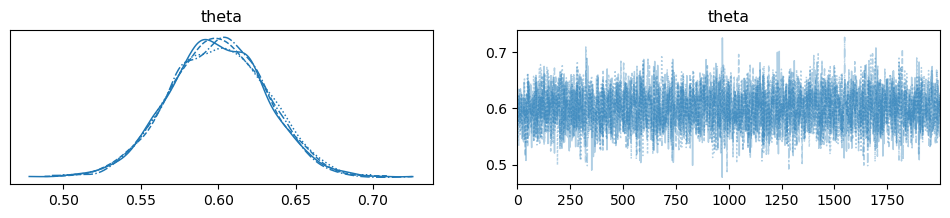

In [53]:
# posterior predictive check
az.plot_trace(trace_1a)
plt.show()

In [54]:
# summary of the trace
az.summary(trace_1a, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.6,0.031,0.55,0.652,0.001,0.0,3720.0,5128.0,1.0


<Axes: xlabel='y'>

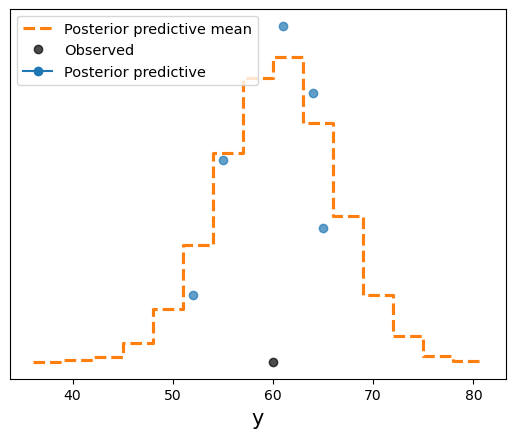

In [63]:
# posterior predictive
az.plot_ppc(
    posterior_1a,
    kind='scatter',
    data_pairs={"y": "y"}
)

### 1.B model

In [64]:
# posterior distribution for 1.a
with pm.Model() as model_1b:
    # prior
    theta = pm.Normal("theta", mu=mean0, sigma=np.sqrt(variance0))

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1b = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1b = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1b = pm.sample_posterior_predictive(trace_1b, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Sampling: [y]


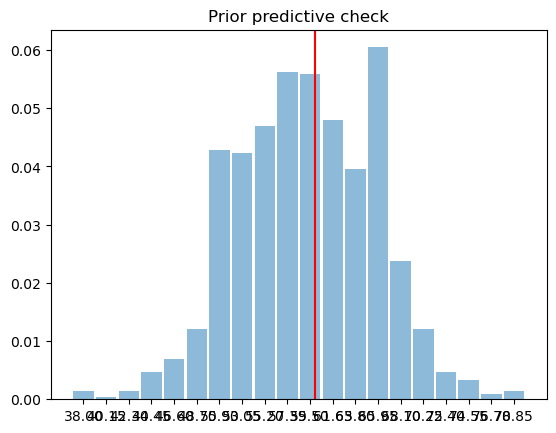

In [65]:
# prior predictive check
az.plot_dist(
    prior_1b.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

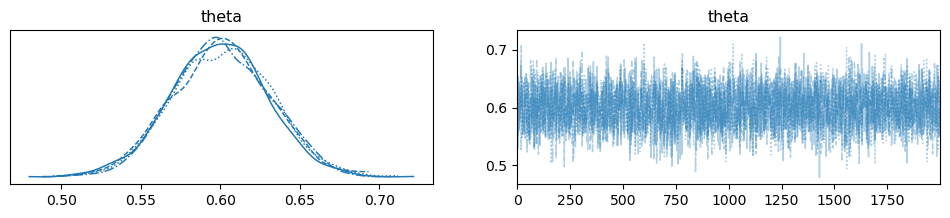

In [66]:
# posterior predictive check
az.plot_trace(trace_1b)
plt.show()

In [67]:
# summary of the trace
az.summary(trace_1b, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.6,0.031,0.552,0.652,0.001,0.0,3583.0,5256.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

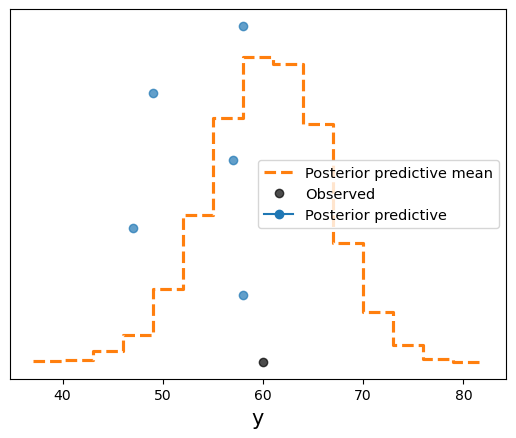

In [68]:
# posterior predictive
az.plot_ppc(
    posterior_1b,
    kind='scatter',
    data_pairs={"y": "y"}
)

### 1.C model

In [71]:
# posterior distribution for 1.a
with pm.Model() as model_1c:
    # prior
    theta = pm.Uniform("theta", lower=0, upper=1)

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1c = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1c = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1c = pm.sample_posterior_predictive(trace_1c, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Sampling: [y]


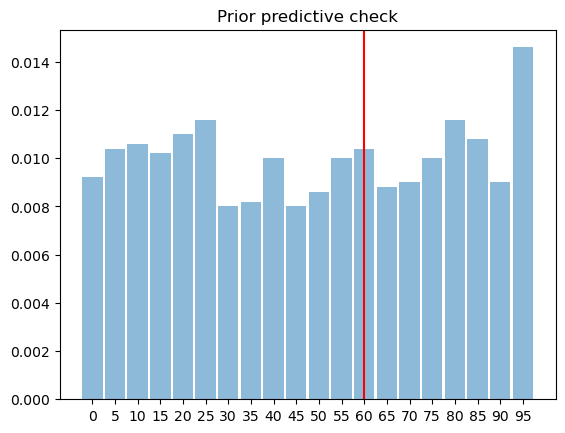

In [72]:
# prior predictive check
az.plot_dist(
    prior_1c.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

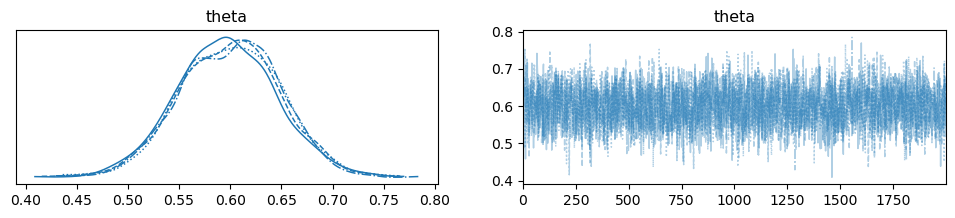

In [73]:
# posterior predictive check
az.plot_trace(trace_1c)
plt.show()

In [74]:
# summary of the trace
az.summary(trace_1c, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.599,0.049,0.523,0.681,0.001,0.001,3237.0,5215.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

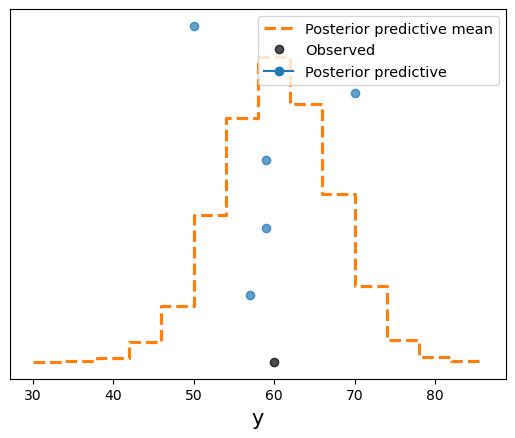

In [75]:
# posterior predictive
az.plot_ppc(
    posterior_1c,
    kind='scatter',
    data_pairs={"y": "y"}
)

## Q1.F

Estimate the odds of giving a credit, i.e. $\phi = \frac{\theta}{1-\theta}$, using the three different priors

In [76]:
# 2005 params
n_obs = 100
n_success = 60

#### 1.A model

In [77]:
# posterior distribution for 1.a
with pm.Model() as model_1a:
    # prior
    theta = pm.Beta("theta", alpha=alpha0, beta=beta0)
    phi = pm.Deterministic("phi", theta/(1-theta))

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1a = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1a = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1a = pm.sample_posterior_predictive(trace_1a, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
Sampling: [y]


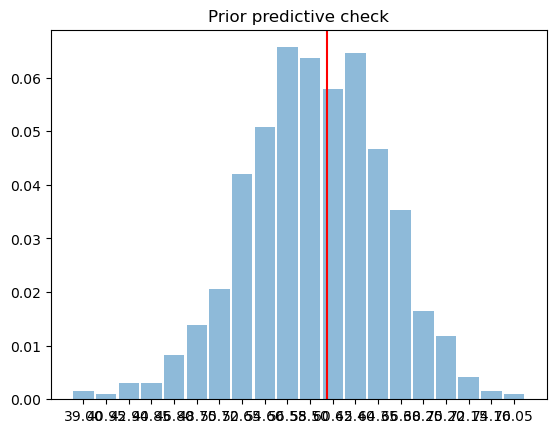

In [78]:
# prior predictive check
az.plot_dist(
    prior_1a.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

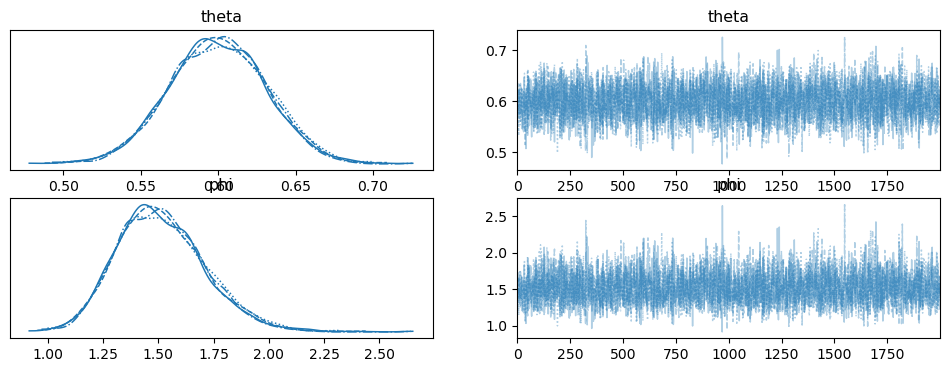

In [79]:
# posterior predictive check
az.plot_trace(trace_1a)
plt.show()

In [80]:
# summary of the trace
az.summary(trace_1a, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.600,0.031,0.550,0.652,0.001,0.000,3720.0,5128.0,1.0
phi,1.514,0.200,1.194,1.831,0.003,0.002,3720.0,5128.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

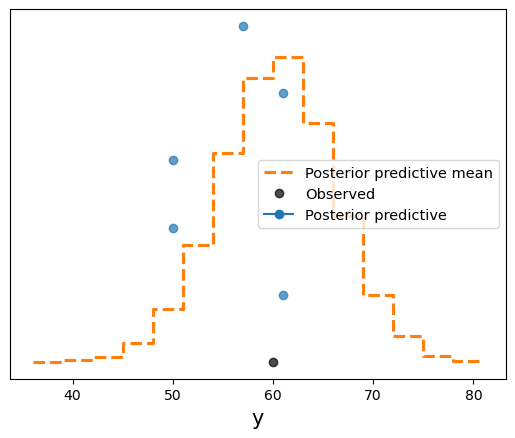

In [81]:
# posterior predictive
az.plot_ppc(
    posterior_1a,
    kind='scatter',
    data_pairs={"y": "y"}
)

### 1.B model

In [82]:
# posterior distribution for 1.a
with pm.Model() as model_1b:
    # prior
    theta = pm.Normal("theta", mu=mean0, sigma=np.sqrt(variance0))
    phi = pm.Deterministic("phi", theta/(1-theta))

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1b = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1b = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1b = pm.sample_posterior_predictive(trace_1b, random_seed=42)

Sampling: [theta, y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Sampling: [y]


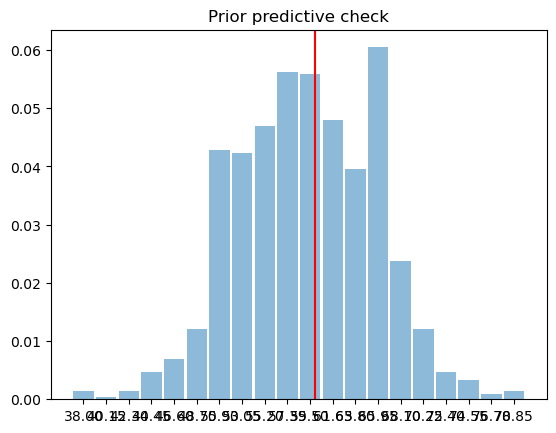

In [83]:
# prior predictive check
az.plot_dist(
    prior_1b.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

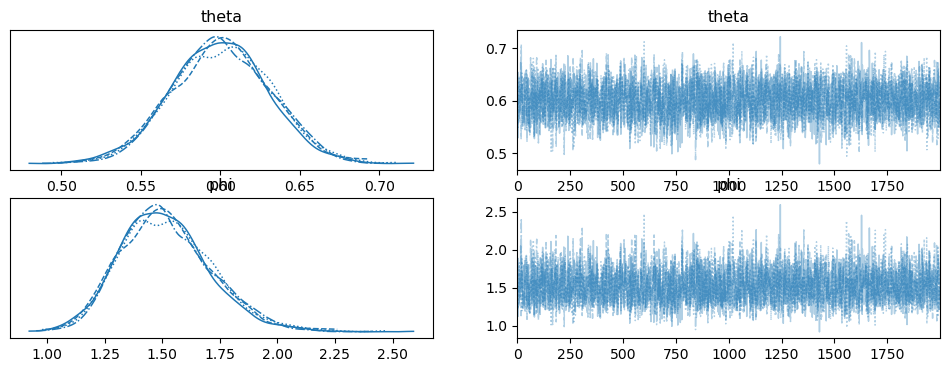

In [84]:
# posterior predictive check
az.plot_trace(trace_1b)
plt.show()

In [85]:
# summary of the trace
az.summary(trace_1b, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.600,0.031,0.552,0.652,0.001,0.000,3583.0,5256.0,1.0
phi,1.518,0.199,1.197,1.833,0.003,0.002,3583.0,5256.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

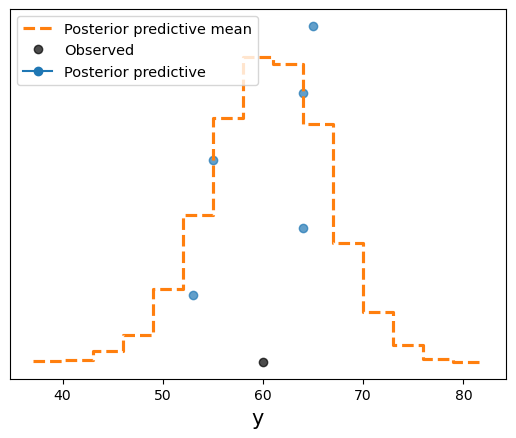

In [86]:
# posterior predictive
az.plot_ppc(
    posterior_1b,
    kind='scatter',
    data_pairs={"y": "y"}
)

### 1.C model

In [87]:
# posterior distribution for 1.a
with pm.Model() as model_1c:
    # prior
    theta = pm.Uniform("theta", lower=0, upper=1)
    phi = pm.Deterministic("phi", theta/(1-theta))

    # likelihood
    y = pm.Binomial("y", n=n_obs, p=theta, observed=n_success)

    # sample
    prior_1c = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace_1c = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior_1c = pm.sample_posterior_predictive(trace_1c, random_seed=42)

Sampling: [theta, y]
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [theta]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 13 seconds.
Sampling: [y]


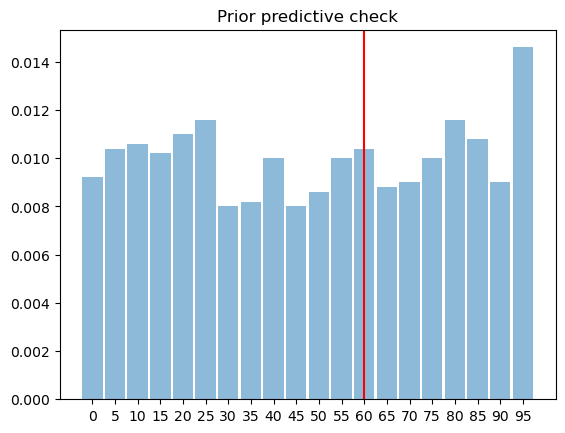

In [88]:
# prior predictive check
az.plot_dist(
    prior_1c.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5}
)

# add vline at observed 60
plt.axvline(60, color='red')
plt.title("Prior predictive check")
plt.show()

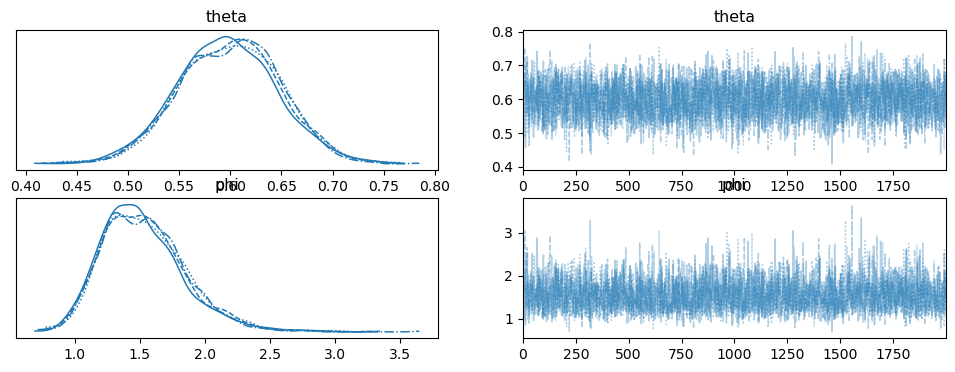

In [89]:
# posterior predictive check
az.plot_trace(trace_1c)
plt.show()

In [90]:
# summary of the trace
az.summary(trace_1c, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta,0.599,0.049,0.523,0.681,0.001,0.001,3237.0,5215.0,1.0
phi,1.531,0.321,1.010,2.001,0.006,0.004,3237.0,5215.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

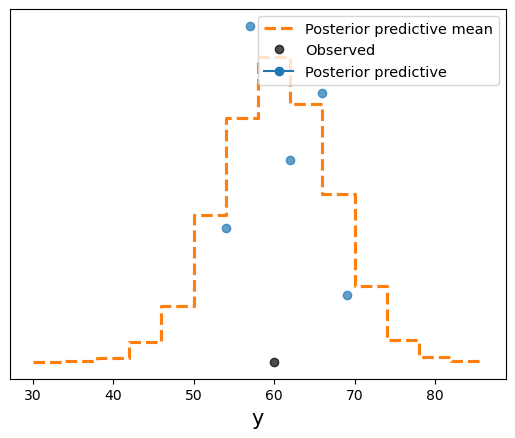

In [91]:
# posterior predictive
az.plot_ppc(
    posterior_1c,
    kind='scatter',
    data_pairs={"y": "y"}
)

# Q2: Company Utilities
The monthly utilities of a company have a distribution $\mathcal{N}(\mu, \sigma^{2})$ (here the variance is given, not the precision). Suppose that a sample of 10 months of this company resulted in the following utilities: (212, 207, 210, 196, 223, 193, 196, 210, 202, 221).


## Q2.A: Estimate $\mu$ and $\sigma^2$ 

The uncertainty about the average annual profit $\mu$ can be represented by a $\mathcal{N}(200, 40)$ distribution, and the uncertainty about the standard deviation of the monthly profits can be represented by a $G(10, 1)$ distribution. Estimate $\mu$ and $\sigma^2$ using the posterior distribution.

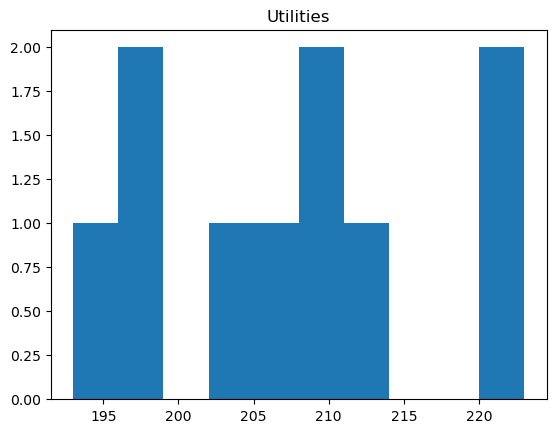

In [149]:
# data
data_utilities = np.array([212, 207, 210, 196, 223, 193, 196, 210, 202, 221])

# hist
plt.hist(data_utilities)
plt.title("Utilities")
plt.show()

In [150]:
# model
with pm.Model() as model2_a:
    # prior
    mu = pm.Normal("mu", mu=200, sigma=40)
    sigma = pm.Gamma("sigma", alpha=10, beta=1)

    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data_utilities)

    # sample
    prior2_a = pm.sample_prior_predictive(samples=1000, random_seed=42)
    trace2_a = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior2_a = pm.sample_posterior_predictive(trace2_a, random_seed=42)

Sampling: [mu, sigma, y]


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 15 seconds.
Sampling: [y]


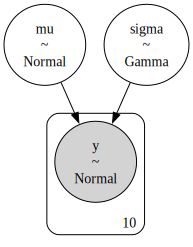

In [151]:
# look causal graph
pm.model_to_graphviz(model2_a)

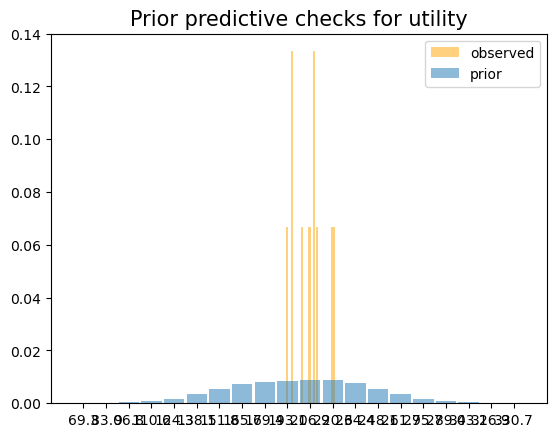

In [152]:
# plot obs data
az.plot_dist(
    data_utilities,
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5},
    label="observed",
    color="orange"
)

# prior predictive check
az.plot_dist(
    prior2_a.prior_predictive["y"],
    kind='hist',
    hist_kwargs={"bins": 20, "alpha": 0.5},
    label="prior"
)

# show plot
plt.legend()
# add title
plt.title('Prior predictive checks for utility', fontsize=15)
plt.show()

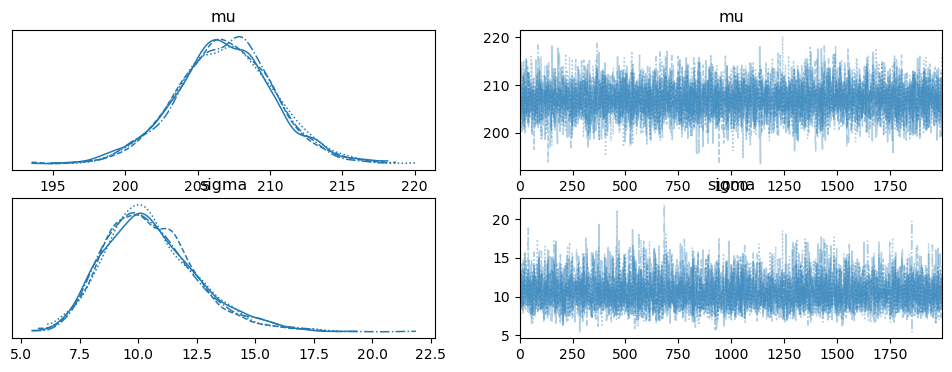

In [153]:
# posterior predictive check
az.plot_trace(trace2_a)
plt.show()

In [154]:
# summary of the trace
az.summary(trace2_a, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,206.922,3.390,200.986,212.265,0.042,0.029,6702.0,5068.0,1.0
sigma,10.541,1.984,7.383,13.699,0.026,0.018,5886.0,4666.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


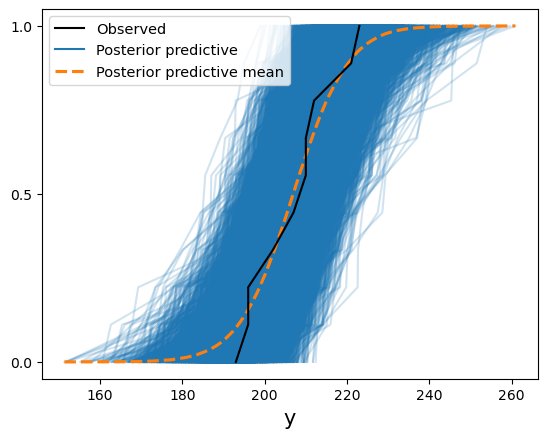

In [155]:
# posterior predictive
az.plot_ppc(
    posterior2_a,
    kind='cumulative',
    data_pairs={"y": "y"}
)

## Q2.B: Non-informative prior

In [156]:
# model
with pm.Model() as model2_b:
    # prior
    mu = pm.Flat("mu")  # non-informative prior
    sigma = pm.Flat("sigma")  # non-informative prior (maybe here)

    # likelihood
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=data_utilities)

    # sample
    trace2_b = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior2_b = pm.sample_posterior_predictive(trace2_b, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [mu, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 14 seconds.
There were 32 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


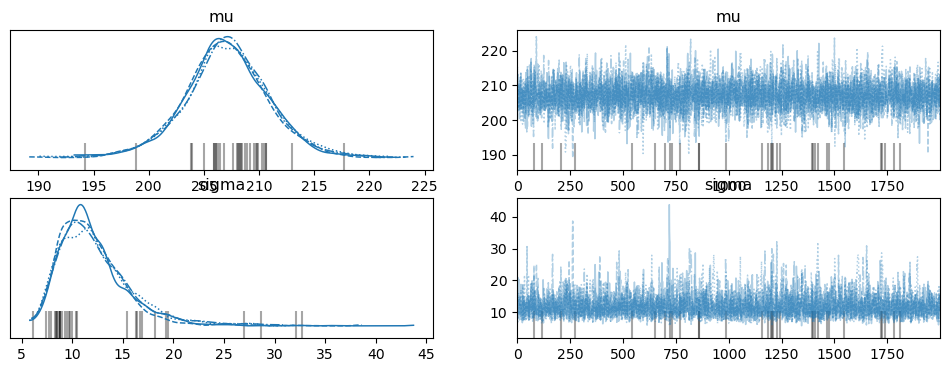

In [157]:
# posterior predictive check
az.plot_trace(trace2_b)
plt.show()

In [158]:
# summary of the trace
az.summary(trace2_b, hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,207.07,3.950,200.857,213.717,0.059,0.041,4624.0,4223.0,1.0
sigma,12.15,3.561,6.997,16.858,0.073,0.055,3083.0,2605.0,1.0


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


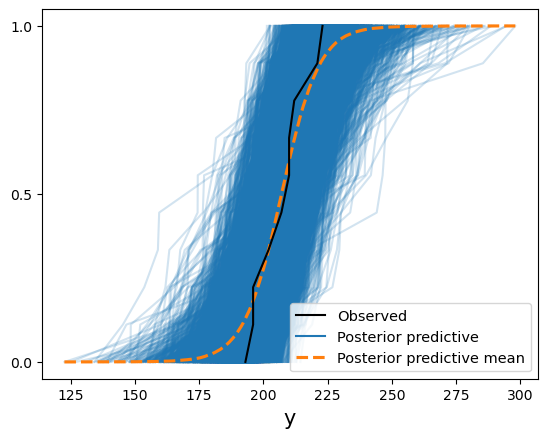

In [159]:
# posterior predictive
az.plot_ppc(
    posterior2_b,
    kind='cumulative',
    data_pairs={"y": "y"}
)

# Q3: S&P Grades
Here contains the data of the S&P and Moody's ratings for 20 financial companies (calificaciones.txt). Do a complete Bayesian analysis of the data, adjusting a linear regression model, taking as the response variable the S&P ratings and as the explanatory variable the Moody's ratings.

Data is on `calificaciones.txt`.

In [3]:
## Step 1: Load Data from txt file with tab delimiter
# load data
df_sp_moodys = pd.read_csv("../data/calificaciones.txt", delimiter="\s+")
df_sp_moodys.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   SP      20 non-null     float64
 1   MO      20 non-null     float64
dtypes: float64(2)
memory usage: 452.0 bytes


array([[<Axes: title={'center': 'SP'}>, <Axes: title={'center': 'MO'}>]],
      dtype=object)

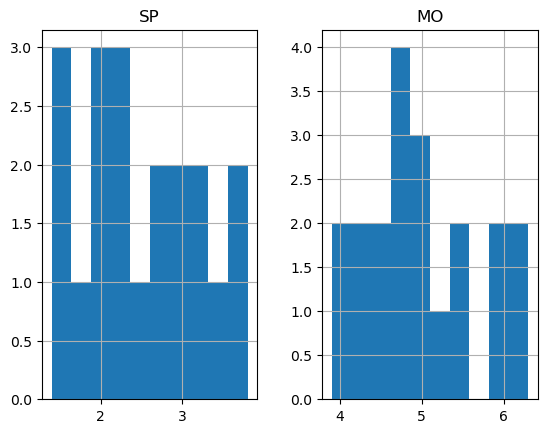

In [4]:
## Step 2: Look at the data
df_sp_moodys.hist()

In [5]:
## Step 2: Look at the data
df_sp_moodys.describe()

,SP,MO
count,20.000000,20.00000
mean,2.500000,5.00000
std,0.719649,0.69282
min,1.400000,3.90000
25%,1.975000,4.57500
50%,2.400000,4.85000
75%,3.025000,5.42500
max,3.800000,6.30000


Moodys has the following grades:
- Aaa
- Aa
- A
- Baa
- Ba
- B
- Caa
- Ca
- C

S&P has the following grades:
- AAA
- AA+
- AA
- AA-
- A+
- A
- A-
- BBB+
- BBB
- BBB-
- BB+
- BB
- BB-
- B+
- B
- B-
- CCC
- CC
- C

In comparisson, we can expect more dispersion in the S&P grades, as they have more categories. As well, in this exercise the grades are numerical, so we can't assert that the grades respect the order of the categories.

In [6]:
## Step 3: Linear regression
with pm.Model() as model3:
    # xdata
    xdata = pm.ConstantData("x", df_sp_moodys["MO"], dims="obs_id")

    # prior
    intercept = pm.Normal("intercept", mu=2.5, sigma=1)
    slope = pm.Normal("slope", mu=0, sigma=1)
    tau = pm.Gamma("tau", alpha=0.1, beta=0.1)
    sigma = pm.Deterministic("sigma", 1/pm.math.sqrt(tau))

    # likelihood
    mu = pm.Deterministic("mu", intercept + slope * xdata, dims="obs_id")
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=df_sp_moodys["SP"], dims="obs_id")

    # sample
    trace3 = pm.sample(2000, tune=1000, chains=4, random_seed=42, cores=4)
    posterior3 = pm.sample_posterior_predictive(trace3, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, slope, tau]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 2_000 draw iterations (4_000 + 8_000 draws total) took 20 seconds.
There were 4 divergences after tuning. Increase `target_accept` or reparameterize.
Sampling: [y]


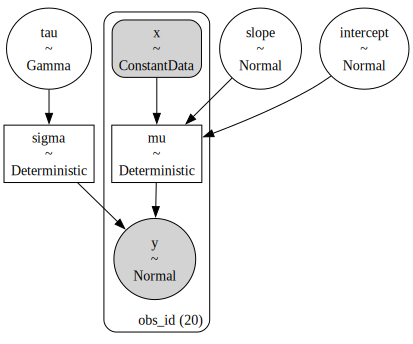

In [7]:
# look causal graph
pm.model_to_graphviz(model3)

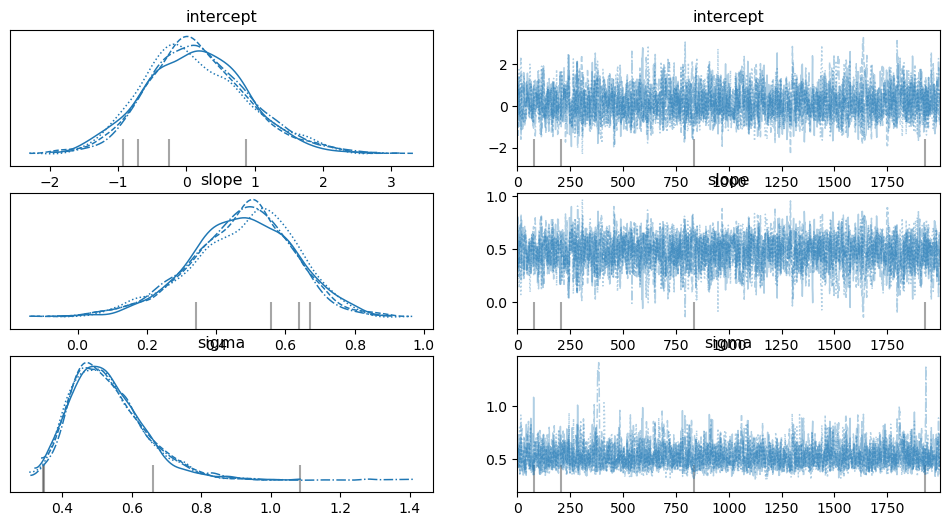

In [8]:
# posterior predictive check
az.plot_trace(trace3, var_names=["intercept", "slope", "sigma"])
plt.show()

In [9]:
# summary of the trace
az.summary(trace3,  var_names=["intercept", "slope", "sigma"], hdi_prob=0.9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,0.158,0.755,-1.074,1.392,0.017,0.013,1884.0,2326.0,1.0
slope,0.475,0.150,0.233,0.721,0.003,0.002,1900.0,2243.0,1.0
sigma,0.531,0.110,0.366,0.695,0.003,0.002,1921.0,2174.0,1.0


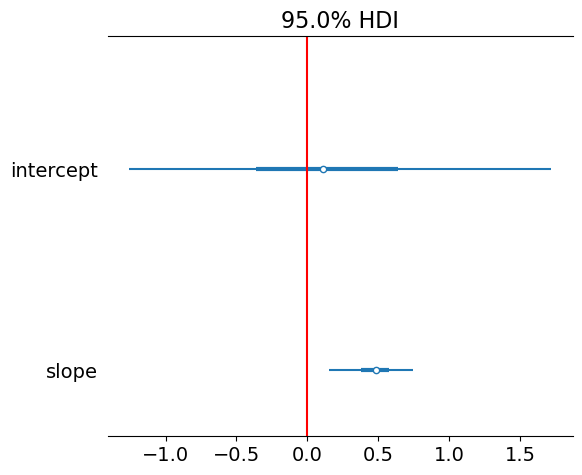

In [10]:
# posterior regression
az.plot_forest(trace3, var_names=["intercept", "slope"], combined=True, hdi_prob=0.95)

# draw vline at 0
plt.axvline(0, color='red')
plt.show()

array([<Axes: title={'center': 'intercept'}>,
       <Axes: title={'center': 'slope'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

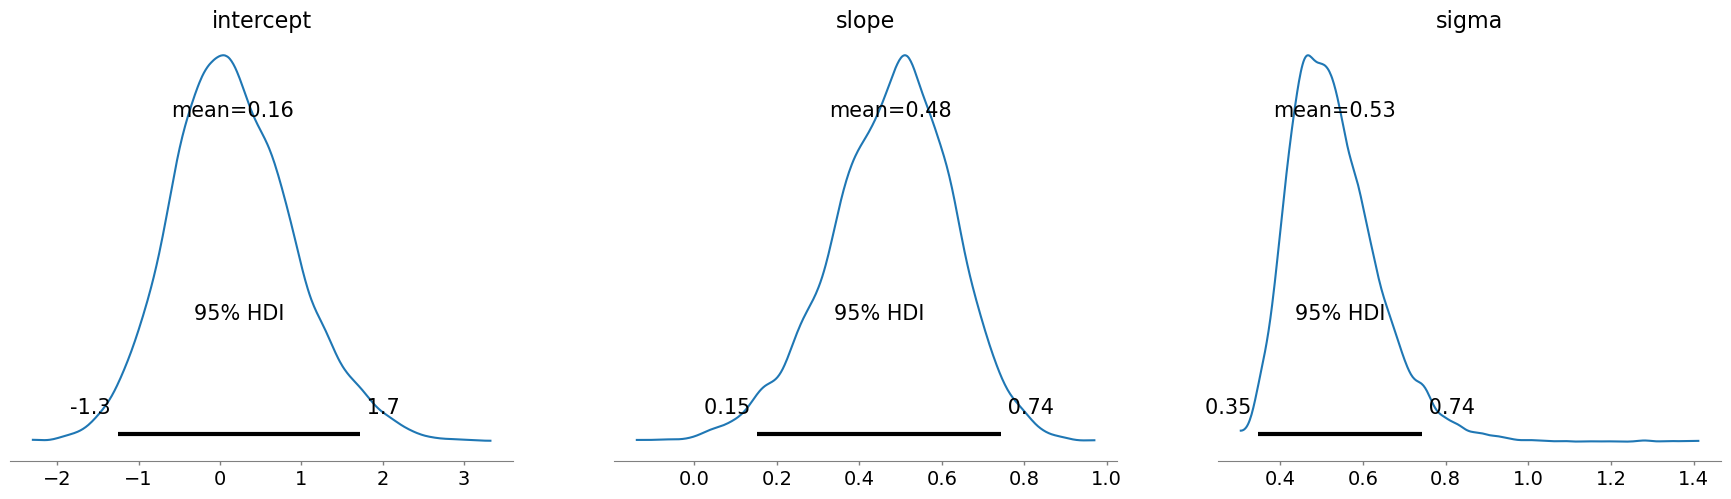

In [11]:
# plot posterior
az.plot_posterior(trace3, var_names=["intercept", "slope", "sigma"], hdi_prob=0.95)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/events.py:82: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/IPython/core/pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


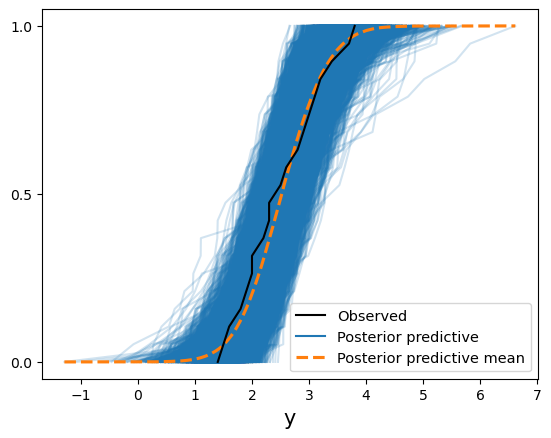

In [12]:
# posterior predictive
az.plot_ppc(
    posterior3,
    kind='cumulative',
    data_pairs={"y": "y"}
)

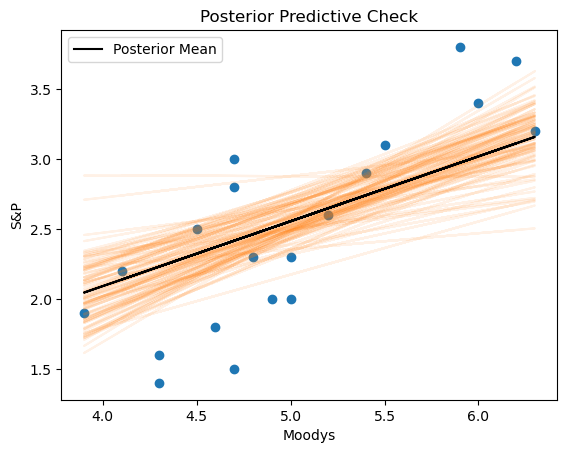

In [13]:
# show inference for each point
post = az.extract(trace3, num_samples=100)
x_plot = xr.DataArray(df_sp_moodys["MO"], dims=["obs_id"])
lines = post["intercept"] + post["slope"] * x_plot

# plot
plt.plot(df_sp_moodys["MO"], lines.transpose(), alpha=0.1, color='C1')
plt.plot(df_sp_moodys["MO"], lines.mean(dim="sample"), color='k', label="Posterior Mean")
plt.scatter(df_sp_moodys["MO"], df_sp_moodys["SP"])
plt.xlabel("Moodys")
plt.ylabel("S&P")
plt.legend()
plt.title("Posterior Predictive Check")
plt.show()


array([[<Axes: xlabel='x', ylabel='y'>]], dtype=object)

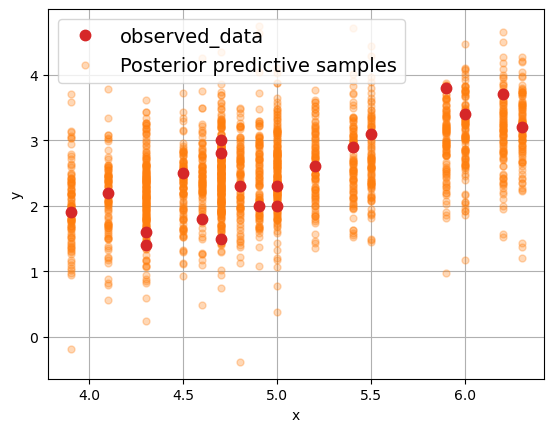

In [14]:
# plot_lm using arviz
az.plot_lm(
    idata=posterior3,
    y='y',
    x='x',
    num_samples=100
)

# Q4: Anual Income
An investigator wishes to evaluate the relationship between the annual salary of mid- and high-level workers (Y, in thousands of dollars) and the quality of work index (X1), number of years of experience (X2), and the success index in publications (X3). The sample consists of 24 workers. Perform a complete Bayesian analysis of the data and obtain the salary predictions for 3 new employees with the following explanatory variables:

- $x_{1} = (5, 4, 17, 6, 0)'$
- $x_{2} = (6, 2, 12, 5, 8)'$
- $x_{3} = (6, 4, 21, 6, 1)'$

Data is on `salarios.txt`



## Q4.1: Bayesian Analysis

In [195]:
## Step 1: Load Data from txt file with tab delimiter
# load data
df_salaries = pd.read_csv("../data/salarios.txt", delimiter="\s+")
df_salaries.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24 entries, 0 to 23
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Y       24 non-null     float64
 1   X1      24 non-null     float64
 2   X2      24 non-null     float64
 3   X3      24 non-null     float64
dtypes: float64(4)
memory usage: 900.0 bytes


array([[<Axes: title={'center': 'Y'}>, <Axes: title={'center': 'X1'}>],
       [<Axes: title={'center': 'X2'}>, <Axes: title={'center': 'X3'}>]],
      dtype=object)

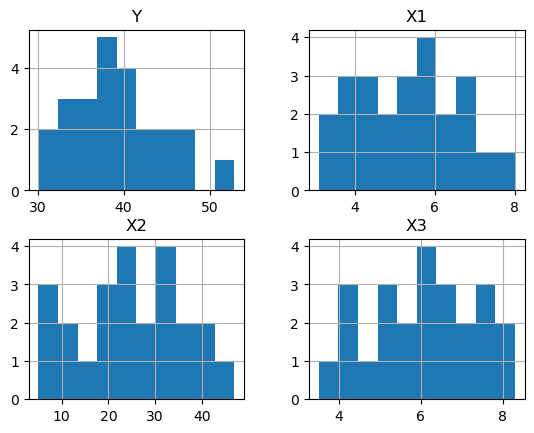

In [196]:
## Step 3: Look at the data
df_salaries.hist()

In [197]:
## Step 2: Look at the data
df_salaries.describe()

,Y,X1,X2,X3
count,24.000000,24.000000,24.000000,24.000000
mean,39.500000,5.358333,24.958333,5.987500
std,5.474288,1.291415,11.222955,1.303611
min,30.100000,3.100000,5.000000,3.500000
25%,35.700000,4.425000,17.250000,5.000000
50%,38.850000,5.400000,25.000000,6.000000
75%,42.925000,6.275000,33.250000,7.000000
max,52.900000,8.000000,47.000000,8.300000


In [198]:
df_salaries.filter(like='X').head(3)

,X1,X2,X3
0,3.5,9.0,6.1
1,5.3,20.0,6.4
2,5.1,18.0,7.4


In [467]:
## Step 3: Multivariate Linear Regression
with pm.Model(
    coords_mutable={"obs_id": df_salaries.index},
    coords={"predictor": df_salaries.filter(like='X').columns}
) as model4:
    # xdata
    x_data = pm.MutableData(
        "x",
        value=df_salaries.filter(like='X'),
        dims=["obs_id", "predictor"]
        )

    # prior
    intercept = pm.Normal("intercept", mu=0, sigma=1)
    betas = pm.Normal("betas", mu=10, sigma=5, dims="predictor")
    sigma = pm.Gamma("sigma", alpha=2, beta=2)

    # likelihood
    mu = pm.Deterministic("mu", intercept + pm.math.dot(x_data, betas))
    y = pm.Normal("y", mu=mu, sigma=sigma, observed=df_salaries["Y"], dims="obs_id")

    # sample
    trace4 = pm.sample(random_seed=42)
    posterior4 = pm.sample_posterior_predictive(trace4, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [intercept, betas, sigma]
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 34 seconds.
Sampling: [y]


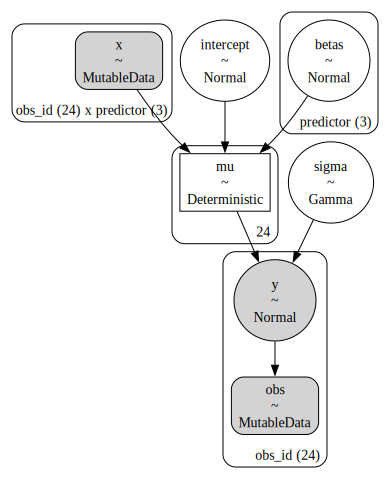

In [465]:
# look causal graph
pm.model_to_graphviz(model4)

/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/backends/matplotlib/traceplot.py:433: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  for chain_id in range(data.dims["chain"])


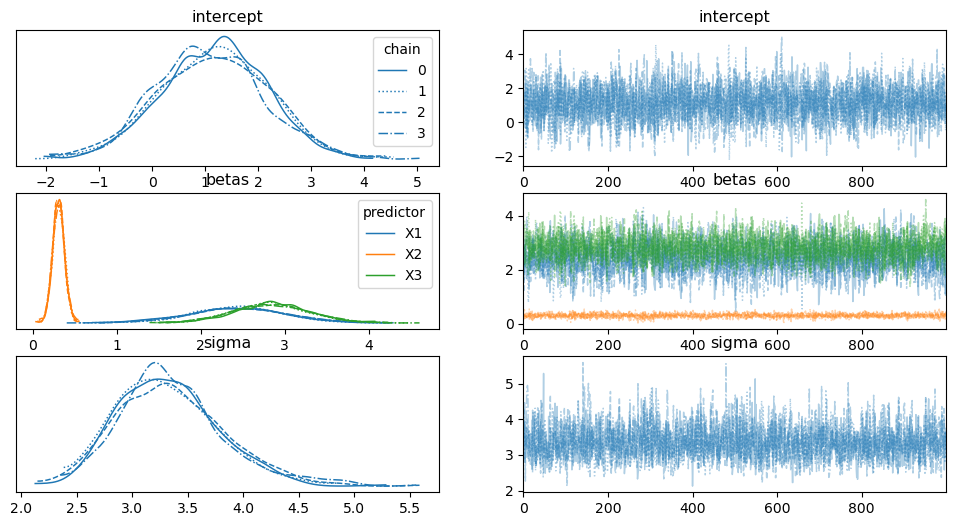

In [453]:
# posterior predictive check
az.plot_trace(trace4, var_names=["intercept", "betas", "sigma"], legend=True)
plt.show()

In [454]:
# summary of the trace
az.summary(trace4, hdi_prob=0.9, var_names=["intercept", "betas", "sigma"])


,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
intercept,1.146,1.037,-0.503,2.852,0.018,0.015,3234.0,2090.0,1.0
betas[X1],2.440,0.565,1.522,3.399,0.013,0.009,2011.0,1970.0,1.0
betas[X2],0.311,0.071,0.189,0.420,0.001,0.001,2360.0,2133.0,1.0
betas[X3],2.840,0.452,2.102,3.596,0.009,0.007,2286.0,2178.0,1.0
sigma,3.337,0.467,2.584,4.078,0.009,0.007,2434.0,2290.0,1.0


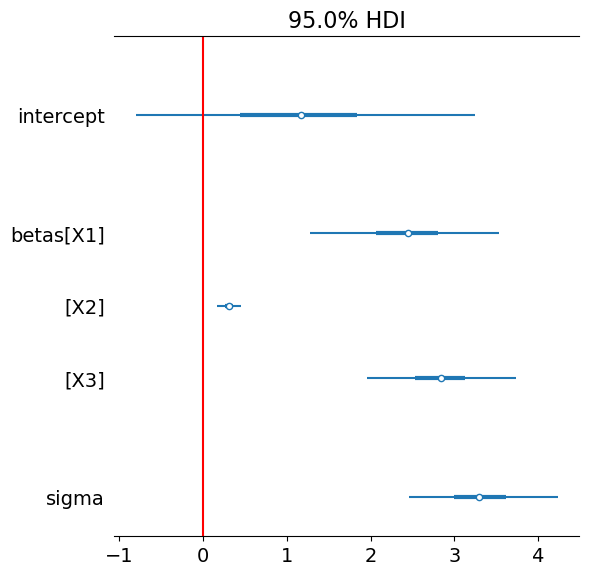

In [455]:
# posterior regression
az.plot_forest(trace4, combined=True, hdi_prob=0.95, var_names=["intercept", "betas", "sigma"])

# draw vline at 0
plt.axvline(0, color='red')
plt.show()

array([[<Axes: title={'center': 'intercept'}>,
        <Axes: title={'center': 'betas\nX1'}>,
        <Axes: title={'center': 'betas\nX2'}>],
       [<Axes: title={'center': 'betas\nX3'}>,
        <Axes: title={'center': 'sigma'}>, <Axes: >]], dtype=object)

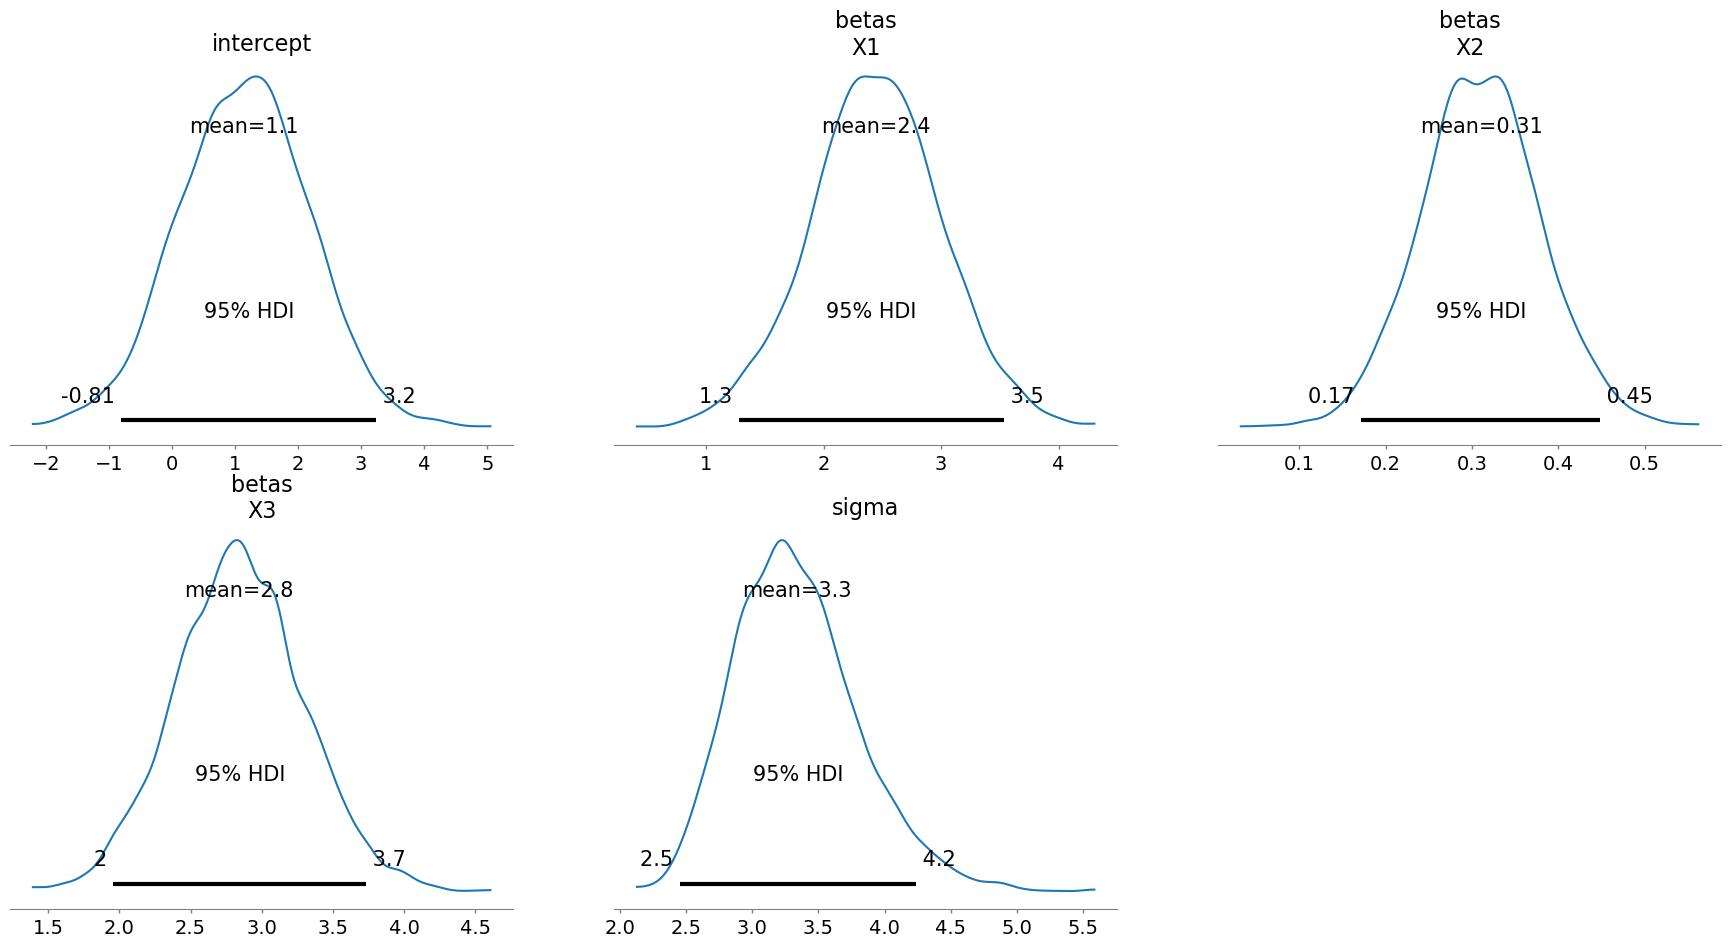

In [456]:
# plot posterior
az.plot_posterior(trace4, hdi_prob=0.95, var_names=["intercept", "betas", "sigma"])


/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:267: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten_pp = list(predictive_dataset.dims.keys())
/Users/ravj/opt/anaconda3/envs/pymc_env/lib/python3.11/site-packages/arviz/plots/ppcplot.py:271: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  flatten = list(observed_data.dims.keys())


<Axes: xlabel='y'>

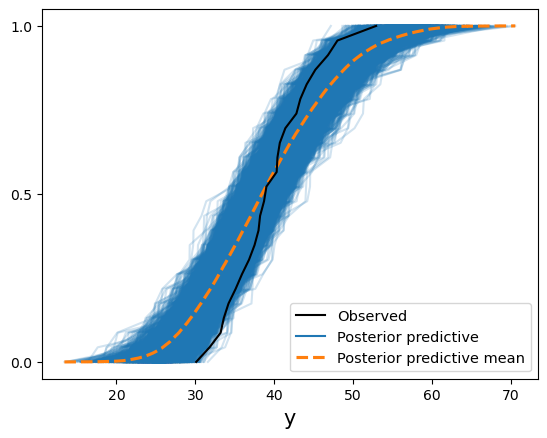

In [457]:
# posterior predictive
az.plot_ppc(
    posterior4,
    kind='cumulative',
    data_pairs={"y": "y"}
)

array([[<Axes: xlabel='obs_id', ylabel='y'>]], dtype=object)

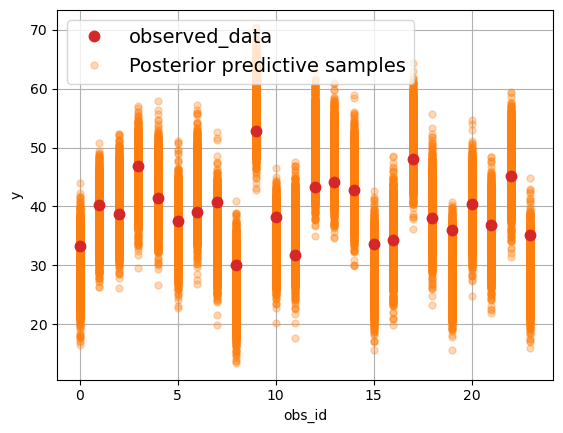

In [458]:
# point estimation
az.plot_lm(
    idata=posterior4,
    y='y',
    num_samples=4000,
    plot_dim="obs_id"
)

In [483]:
model4['y'].eval()

array([110.56925334,  63.00505704, 321.47194509, 109.67463726,
        60.26432344])

In [449]:
model4.coords

{'obs_id': (0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23),
 'predictor': ('X1', 'X2', 'X3')}

## Q4.2: Predict on holdout data

Predict the anual income for the following new employees:

- $x_{1} = (5, 4, 17, 6, 0)'$
- $x_{2} = (6, 2, 12, 5, 8)'$
- $x_{3} = (6, 4, 21, 6, 1)'$


To predict OOS points, look [here](https://www.pymc.io/projects/examples/en/latest/fundamentals/data_container.html#types-of-data-containers)

In [477]:
# new data to predict
df_new_salaries = pd.DataFrame({
    "X1": [5, 4, 17.0, 6, 0],
    "X2": [6.0, 2, 12, 5, 8],
    "X3": [6, 4.0, 21, 6, 1],
})
df_new_salaries

,X1,X2,X3
0,5.0,6.0,6.0
1,4.0,2.0,4.0
2,17.0,12.0,21.0
3,6.0,5.0,6.0
4,0.0,8.0,1.0


In [482]:
# create new data
with model4:
    # new data
    pm.set_data({"x": df_new_salaries}, coords={"obs_id": df_new_salaries.index})

    # add new coords

    # sample
    posterior_pred = pm.sample_posterior_predictive(
        trace4,
        var_names=["y"],
        predictions=True,
        random_seed=42
    )

Sampling: [y]


In [485]:
posterior_pred.predictions["y"].mean(dim=["chain", "draw"]).values

array([ 32.26846925,  22.77179732, 106.00426051,  34.3908121 ,
         6.36433242])

array([[<Axes: title={'center': 'y\n0'}>,
        <Axes: title={'center': 'y\n1'}>,
        <Axes: title={'center': 'y\n2'}>],
       [<Axes: title={'center': 'y\n3'}>,
        <Axes: title={'center': 'y\n4'}>, <Axes: >]], dtype=object)

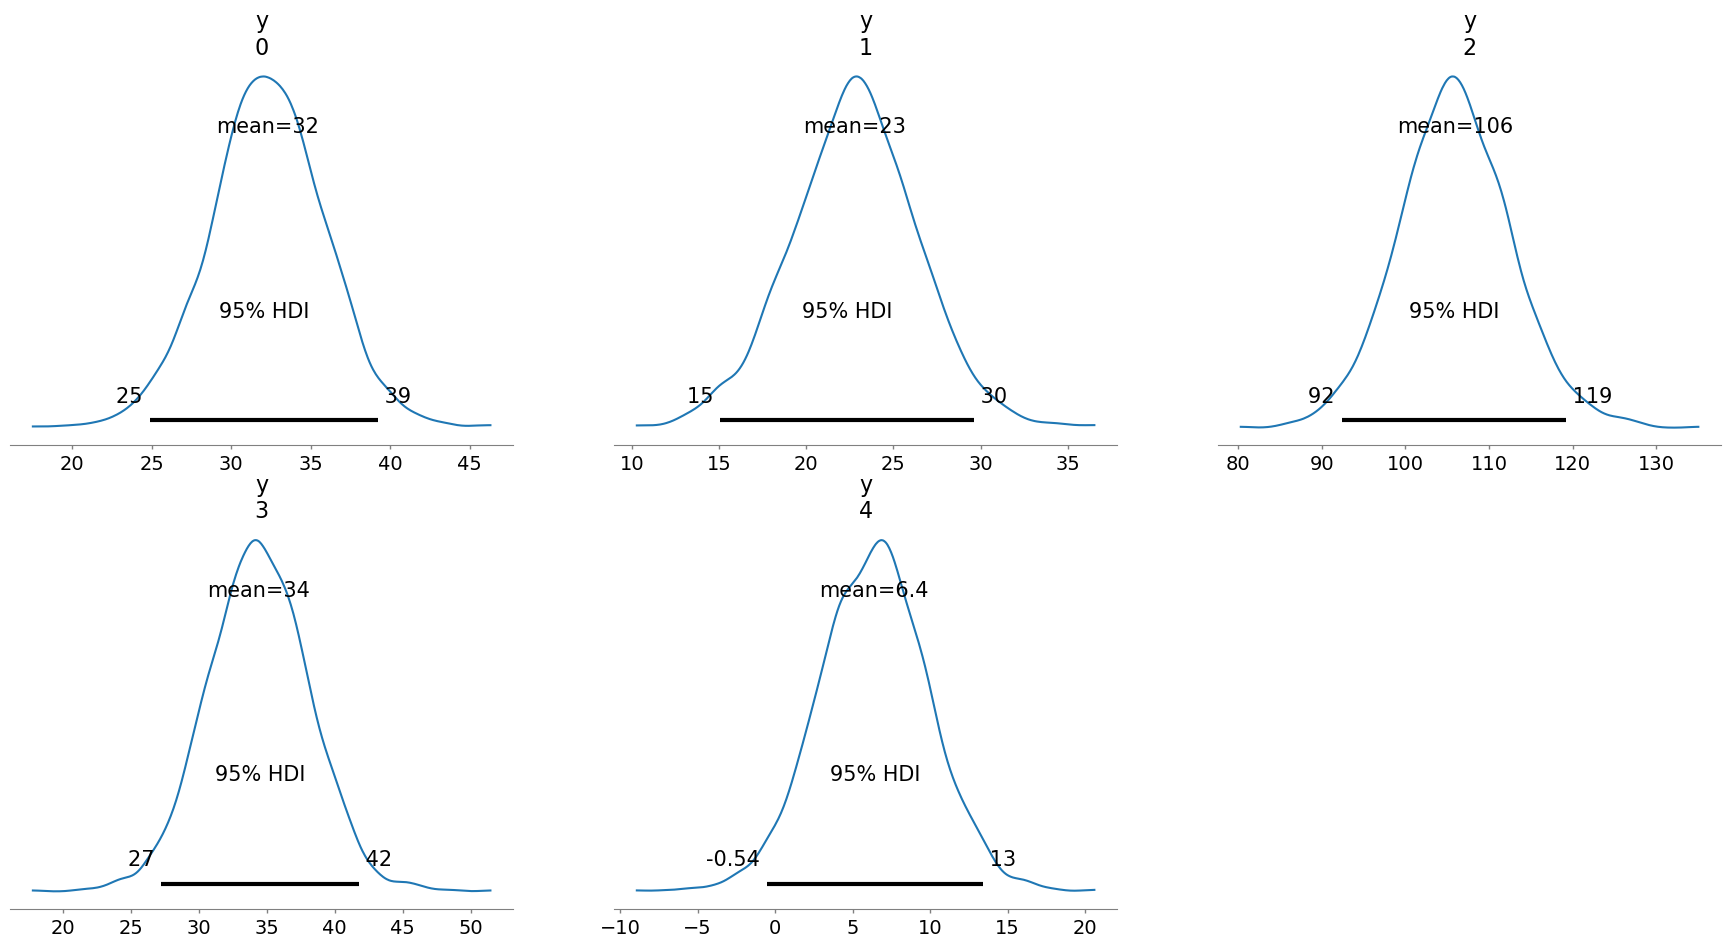

In [486]:
# plot the predictions
az.plot_posterior(posterior_pred, group="predictions", hdi_prob=0.95)

# Sandbox